In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-07-31 21:08:41.198537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 21:08:41.201258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 21:08:41.209089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:08:41.222744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:08:41.226717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:08:41.236817: I tensorflow/core/platform/cpu_feature_gu

# Data preparation

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension to the data
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert data to RGB format
x_train_rgb = np.concatenate([x_train]*3, axis=-1)
x_test_rgb = np.concatenate([x_test]*3, axis=-1)

# Resize images to 32x32 using OpenCV
def resize_images(x, size=(32, 32)):
    resized_images = []
    for img in x:
        resized_img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
        resized_images.append(resized_img)
    return np.array(resized_images)

x_train = resize_images(x_train_rgb)
x_test = resize_images(x_test_rgb)

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


# Search for optimal parameters

In [3]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

x = conv_base.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=conv_base.input, outputs=x)
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 14,881,738 (56.77 MB)

 Trainable params: 166,282 (649.54 KB)

 Non-trainable params: 14,715,456 (56.14 MB)

# Train model

In [4]:
model.fit(x_train, y_train, 
            validation_data=(x_val, y_val),
            epochs=8, 
            batch_size=32)

# Evaluate the final model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}, Test loss: {test_loss}')

Epoch 1/8
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 45ms/step - accuracy: 0.7797 - loss: 0.6390 - val_accuracy: 0.8433 - val_loss: 0.4405
Epoch 2/8
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 76s 45ms/step - accuracy: 0.8493 - loss: 0.4109 - val_accuracy: 0.8597 - val_loss: 0.3897
Epoch 3/8
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 45ms/step - accuracy: 0.8606 - loss: 0.3820 - val_accuracy: 0.8512 - val_loss: 0.4116
Epoch 4/8
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 45ms/step - accuracy: 0.8677 - loss: 0.3577 - val_accuracy: 0.8577 - val_loss: 0.3864
Epoch 5/8
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 45ms/step - accuracy: 0.8745 - loss: 0.3432 - val_accuracy: 0.8573 - val_loss: 0.3852
Epoch 6/8
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.8791 - loss: 0.3307 - val_accuracy: 0.8633 - val_loss: 0.3803
Epoch 7/8
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.8814 - loss: 0.3170 - val_accuracy: 0.8733 - val_loss: 0.3604
Epoch 8/8
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.8848 - loss: 0

# Save model

In [5]:
model.save("model_part_2.keras")

# Classification test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


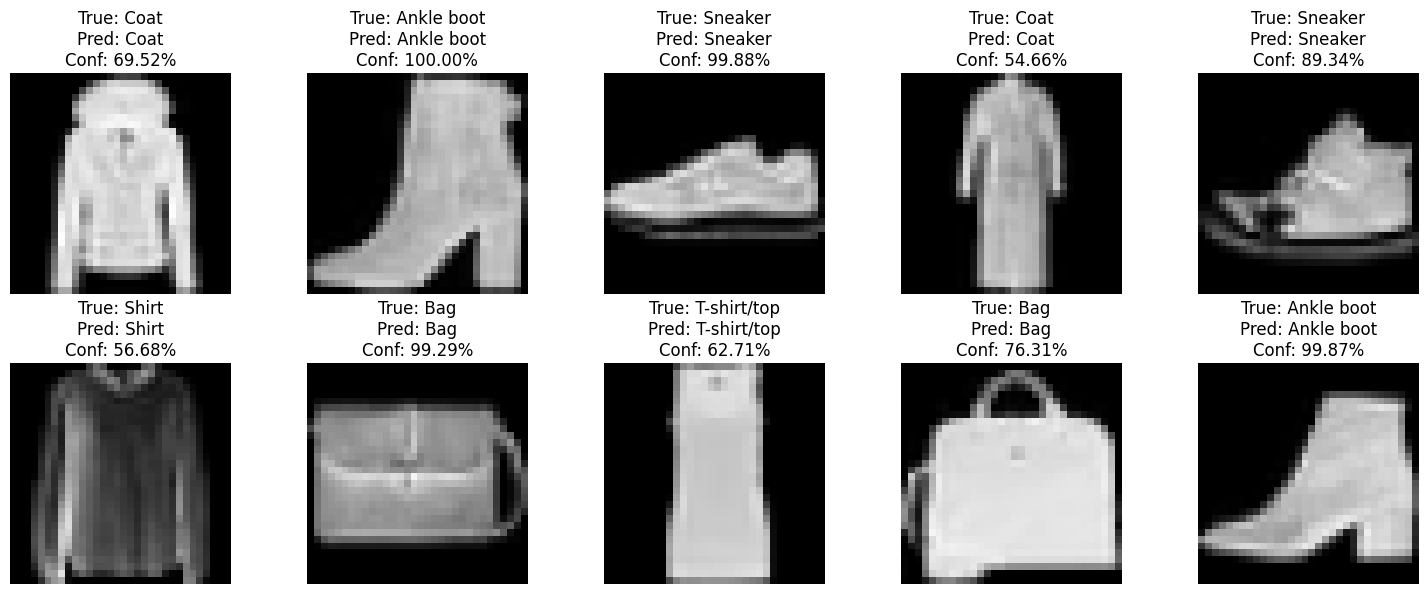

In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Generating a list of unique, random numbers
unique_random_numbers = random.sample(range(len(x_test)), 10)

# Dictionary to map labels to their respective names
fm_label = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Setting up the grid layout
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Iterating over unique random numbers and displaying images with predictions
for ax, sample_num in zip(axes.flatten(), unique_random_numbers):
    # Prepare the image
    img = x_test[sample_num]
    img_reshaped = img.reshape(32, 32, 3)
    prediction = model.predict(np.expand_dims(img, axis=0))
    
    # Get predicted label and confidence
    predicted_probs = prediction[0]  # Assuming prediction is of shape (1, num_classes)
    predicted_label = np.argmax(predicted_probs)
    confidence = predicted_probs[predicted_label] * 100  # Convert to percentage
    
    # Get true label
    true_label = np.argmax(y_test[sample_num])
    
    # Translate labels to names
    true_label_name = fm_label[true_label]
    predicted_label_name = fm_label[predicted_label]

    # Display image with title showing true label, predicted label, and confidence
    ax.imshow(img_reshaped, cmap='gray')
    ax.set_title(f"True: {true_label_name}\nPred: {predicted_label_name}\nConf: {confidence:.2f}%")
    ax.axis('off')

plt.tight_layout()
plt.show()



# Comparison of Previous and Current Tasks

Classification test Homework 9

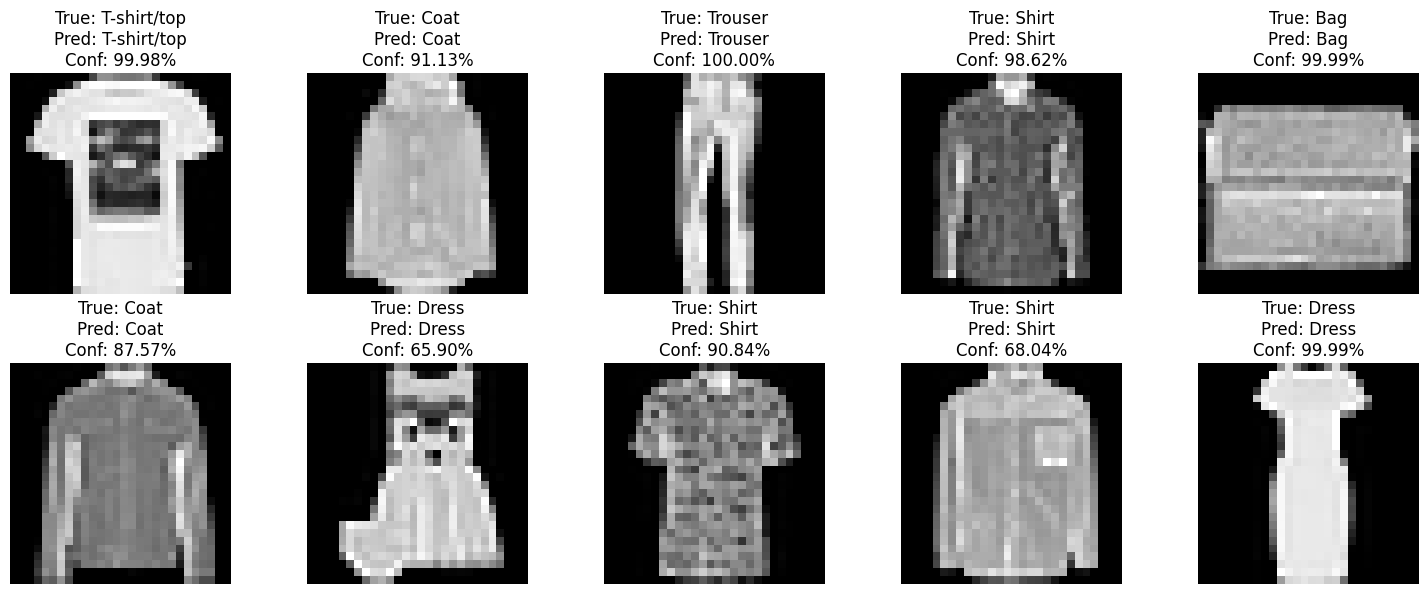

Classification test Homework 10 - part 1

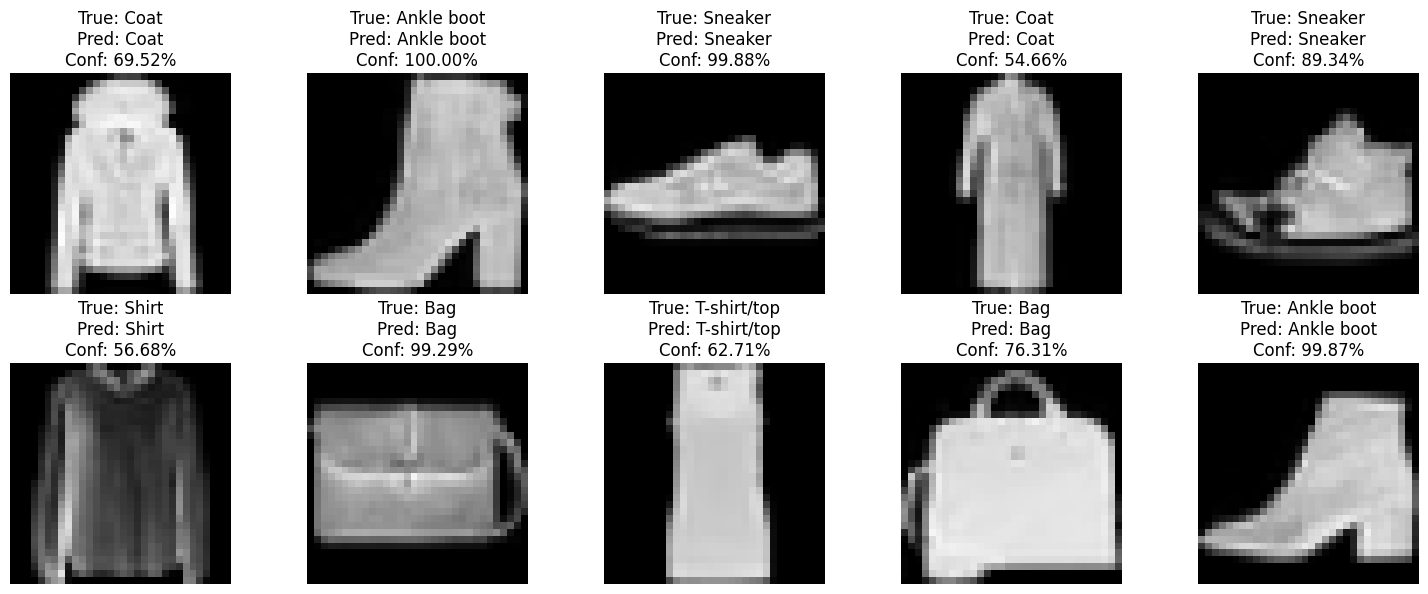

| Metric / Observation                | Homework 9: Dense Neural Network | Homework 10 - part 1: Convolutional Neural Network | Homework 10 - part 2: VGG16 CNN |
|-------------------------------------|----------------------------------|-----------------------------------------------------|-------------------------------------|
| **Test Accuracy**                   | 0.8859                           | 0.9050                                              | 0.8701                              |
| **Test Loss**                       | 0.3291                           | 0.2652                                              | 0.3728                              |
| **Correct Predictions**             | 10 out of 10                     | 10 out of 10                                        | 10 out of 10                        |
| **Confidence Levels**               |                                  |                                                     |                                     |
| - ~55% Confidence                   |                                  |                                                     | 2 predictions                       |
| - ~60% Confidence                   |                                  |                                                     | 1 prediction                  |
| - ~65% Confidence                   | 1 predictions                    |                                                     |                   |
| - ~70% Confidence                   | 1 predictions                    | 1 prediction                                        | 1 predictions                  |
| - ~75% Confidence                   |                                  |                                                     | 1 predictions                  |
| - ~85% Confidence                   |                                  | 1 prediction                                        |                                  |
| - ~90% Confidence                   | 1 prediction                     | 1 prediction                                        | 1 prediction                  |
| - ~100% Confidence                  | Remaining predictions, with one at exactly 100% | Remaining predictions, with multiple at exactly 100% | Remaining predictions, with one at exactly 100% |

# Summary

In Homework 10 - Part 2, the enhanced convolutional neural network, which underwent extended training, achieved a slightly lower accuracy of 87.01% compared to the previous part, and exhibited a higher loss of 0.3728. Despite the increase in training duration, the model's performance showed a decrease in accuracy and an increase in loss. Although the model still correctly classified all test images, the confidence levels for its predictions were more varied, with fewer predictions reaching the highest confidence thresholds compared to Homework 10 - Part 1. This suggests that the extended training did not lead to improvements in performance and may have introduced additional noise or instability into the learning process.